# **Trabajo práctico 0: Algoritmo de Maximización de la Esperanza**

Pre-requisitos para el notebook.

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma
# Based on https://pypi.org/project/torch-kmeans/
from torch_kmeans import KMeans

torch.set_printoptions(sci_mode=False)

PALETTE = ["#9E0000", "#4F9E00", "#009E9E"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## **1. (80 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gaussiano)**

A continuación, implemente el algoritmo de maximización de la esperanza (descrito en el material del curso), usando la definición y descripción de las siguientes funciones como base:

1. **(15 puntos)** Implemente la función $\textit{generate\_data}$ la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K=2$ funciones de densidad **Gaussianas**. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{Nx1}$.

    a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad **Gaussianas** usando los parámetros para inicializar los datos, en la misma figura (gráfico). Escoja 3 conjuntos de parámetros para mostrar los 3 dataset resultantes.

In [12]:
# Constants
BELL_Y_OFFSET = 0.005
BELL_DISTANCE_FACTOR = 0.2

MU_SHIFT_COEFFICIENT = 30
MU_SPREAD_COEFFICIENT = 10

SIGMA_SHIFT_COEFFICIENT = 3
SIGMA_SPREAD_COEFFICIENT_START = 1.0
SIGMA_SPREAD_COEFFICIENT_END = 10.0

#This function will generate the distribution data based on the desired parameters.
def generate_data(n_observations, parameters):
    mus = parameters[:, 0][:, None].squeeze(1)
    sigmas = parameters[:, 1][:, None].squeeze(1)
    distributions = torch.distributions.Normal(mus, sigmas)
    samples = distributions.sample(torch.Size([n_observations,])).t()
    return samples


def init_original_parameters(k_parameters=2):
    # Creates a set of mus that starts on MU_SHIFT_COEFFICIENT and ends on MU_SHIFT_COEFFICIENT * k_parameters
    # with step MU_SHIFT_COEFFICIENT. A random number between 0 and MU_SPREAD_COEFFICIENT is added to each
    # value in the range
    mu_range = torch.range(MU_SHIFT_COEFFICIENT, MU_SHIFT_COEFFICIENT * k_parameters, MU_SHIFT_COEFFICIENT)
    mus = torch.rand(k_parameters) * MU_SPREAD_COEFFICIENT + mu_range

    # Creates a set of sigmas between SIGMA_SHIFT_COEFFICIENT and SIGMA_SPREAD_COEFFICIENT_END
    sigma_spread = torch.rand(1) * (
                SIGMA_SPREAD_COEFFICIENT_END - SIGMA_SPREAD_COEFFICIENT_START) + SIGMA_SPREAD_COEFFICIENT_START
    sigmas = torch.rand(k_parameters) * sigma_spread + SIGMA_SHIFT_COEFFICIENT

    return torch.stack((mus, sigmas), dim=1)

In [13]:
#Function to plot the observations.
def plot_observation(observation, show=True, color=None, title="", show_hist=True, fig=None, ax=None,
                    show_curve=True, y_adjustment=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    if show_hist:
        ax.hist(observation, density=True, bins=20, alpha=0.5, color=color)
    ax.scatter(observation, torch.zeros(observation.size()), s=8, alpha=0.5, color=color)
    if show_curve:
        x_axis = torch.arange(observation.min().item(), observation.max().item(), 0.01)
        mu = torch.mean(observation)
        sigma = torch.std(observation, unbiased=True)
        label = fr'$\mu={round(mu.item(), 2)},\ \sigma={round(sigma.item(), 2)}$'
        ax.plot(x_axis, norm.pdf(x_axis, mu, sigma), color=color, label=label)
        ax.legend()
    if title != "":
        ax.set_title(title)
    if y_adjustment:
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min - 0.01, y_max)
    if show:
        plt.show()

2. **(5 puntos)** Implemente la función $\textit{init\_random\_parameters}$ la cual genere una matriz de $P\in\mathbb{R}^{Kx2}$ dimensiones, con los parámetros de las funciones de densidad **Gaussiana** generados completamente al azar.

    a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [14]:
#Function to initialize the random parameters.
def init_random_parameters(k_parameters=2):
    # Creates a range of mus between MU_SHIFT_COEFFICIENT and MU_SHIFT_COEFFICIENT * k_parameters
    mus = torch.rand(k_parameters) * (MU_SHIFT_COEFFICIENT * k_parameters - MU_SHIFT_COEFFICIENT) + MU_SHIFT_COEFFICIENT
    # Creates a range of sigmas between SIGMA_SPREAD_COEFFICIENT_START and SIGMA_SPREAD_COEFFICIENT_END
    sigmas = (torch.rand(k_parameters) * (SIGMA_SPREAD_COEFFICIENT_END - SIGMA_SPREAD_COEFFICIENT_START) +
              SIGMA_SPREAD_COEFFICIENT_START)
    return torch.stack((mus, sigmas), dim=1)

3. **(20 puntos)** Implemente la función  $\textit{calculate\_likelihood\_gaussian\_observation(x\_n, mu\_k, sigma\_k)}$ la cual calcule la verosimilitud de una observación específica $X_{n}$, para una función de densidad Gaussiana con parámetros $\mu_{k}$ y $\sigma_{k}$.
Realice la correción pertinente al calculo de la función de verosimilitud para evitar el problema de $\textit{under flow}$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [15]:
#Function to calculate hte likelihhod on the gaussian observations.
def calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
    def log_gaussian_function(x, mu, sigma):
        return (-1/2) * torch.log(2 * torch.pi * sigma**2) - ((x-mu)**2/(2 * sigma**2))
    return log_gaussian_function(x_n, mu_k, sigma_k)

In [16]:
# Pending prueba unitaria

4. **(10 puntos)** Implemente la función $\textit{calculate\_membership\_dataset(X\_dataset,Parameters\_matrix)}$, la cual, usando la matriz de parámetros $P$ y la función anteriormente implementada calculate_likelihood_gaussian_observation, defina por cada observación $X_{n}\in X$ la pertenencia o membresía a  cluster $k=1,...,K$, en una matriz binaria $M\in\mathbb{R}^{NxK}$. Retorne tal matriz de membresía $M$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados

In [17]:
#Función
def calculate_membership_dataset(observations, parameters):
    mean = parameters[:, 0].unsqueeze(0)
    std = parameters[:, 1].unsqueeze(0)
    observations_expanded = observations.unsqueeze(-1)
    log_likelihoods = calculate_likelihood_gaussian_observation(observations_expanded, mean, std)
    max_values, _ = torch.max(log_likelihoods, dim=-1, keepdim=True)
    one_hot_membership_matrix = (log_likelihoods == max_values).to(torch.float)
    return one_hot_membership_matrix

In [18]:
# Pending prueba unitaria

5. **(10 puntos)** Implemente la función $\textit{recalculate\_parameters(X\_dataset, Membership\_data)}$, la cual recalcule los parámetros de las funciones de densidad Gaussianas representandas en la matriz $P$, de acuerdo a lo representado en la matriz de membresía $M$.

    a)   Use las funciones $\textit{mean}$ y $\textit{std}$ de pytorch para ello. Intente prescindir al máximo de estructuras de repetición tipo $\textit{for}$.

In [19]:
#Function to recalculate the parameters based on the membership matriz.
def recalculate_parameters(x_dataset, membership_data):
    values_per_membership = torch.transpose(membership_data, 0, 1) * x_dataset
    new_parameters = []
    for t_membership in values_per_membership:
        non_zero_mask = t_membership != 0
        t_membership = t_membership[non_zero_mask]
        new_mu = torch.mean(t_membership)
        new_std = torch.std(t_membership)
        if new_mu.item() != new_mu.item() or new_std.item() != new_std.item():  # if nan
            params = init_random_parameters(1)
            new_mu = params[0][0]
            new_std = params[0][1]
        new_parameters.append([new_mu, new_std])
    return torch.Tensor(new_parameters)

6. **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (describalo en una tabla). Hagalo para los 3 conjuntos de datos generados anteriormente.

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteración y los parámetros iniciales.

    b) Comente los resultados.

In [27]:
def expectation_maximization(samples, iterations=5, distributions_to_plot=3, run_number=1, heuristic=False):
    parameters = init_random_parameters(samples.size(0)) if not heuristic else  ""#  heuristic_improvement(samples)
    plot_gaussian_distribution_and_observations(parameters, samples, title=f"Iteration #0 | Run #{run_number}")
    plots_to_show = torch.randperm(iterations - 1)[:distributions_to_plot] + 1
    for iteration in range(1, iterations + 1):
        membership_data = calculate_membership_dataset(torch.flatten(samples), parameters)
        parameters = recalculate_parameters(torch.flatten(samples), membership_data)
        if iteration in plots_to_show:
            plot_gaussian_distribution_and_observations(parameters, samples,
                                                        title=f'Iteration #{iteration} | Run #{run_number}')
    plot_gaussian_distribution_and_observations(parameters, samples,
                                                title=f'Final Iteration #{iterations} | Run #{run_number}')
    return parameters

#Function to plot the results.
def plot_gaussian_distribution_and_observations(distribution_parameters, observations, title=""):
    """ What it does

    Summary

    Args:

    Returns:
    """
    fig, ax = plt.subplots()

    if observations.dim() > 1:
        for index, sample in enumerate(observations):
            plot_observation(sample, color=PALETTE[index % len(PALETTE)], show=False, show_hist=False, fig=fig, ax=ax,
                             y_adjustment=False, show_curve=False)
    else:
        plot_observation(observations, show=False, show_hist=False, fig=fig, ax=ax, y_adjustment=False)

    for index, parameters in enumerate(distribution_parameters):
        mu = parameters[0]
        sigma = parameters[1]
        min_value = torch.min(observations)
        max_value = torch.max(observations)
        dist = (max_value - min_value) * BELL_DISTANCE_FACTOR
        x_axis = torch.arange(min_value.item() - dist, max_value.item() + dist)
        ax.plot(x_axis, norm.pdf(x_axis, mu, sigma) + BELL_Y_OFFSET,
                label=r'$\mu_' + str(index + 1) + r'=' + str(round(mu.item(), 2)) +
                      r',\ \sigma_' + str(index + 1) + '=' + str(round(sigma.item(), 2)) + r'$',
                color=PALETTE[index % len(PALETTE)])

    if title != "":
        ax.set_title(title)

    plt.legend()
    plt.show()

7. **(10 puntos)** Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente.

    a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.

In [21]:
#Heuristic improvement proposal, using kmeans to estimate the signas and mus.
def heuristic_improvement(test_data):
    k = test_data.size(0)
    model = KMeans(n_clusters=k)
    test_data = test_data.unsqueeze(2)
    result = model(test_data)
    # Mu estimation
    centroides = result.centers
    centroides = centroides.flatten()
    centroides = centroides[::k]
    centroides = centroides.reshape(k, 1)
    # Sigma estimation
    inertia = result.inertia
    varianza = torch.zeros(k, 1)
    for idx, elem in enumerate(inertia):
        varianza[idx] = torch.sqrt(elem / test_data.size(1))
    new_params = torch.cat((centroides, varianza), dim=1)
    return new_params

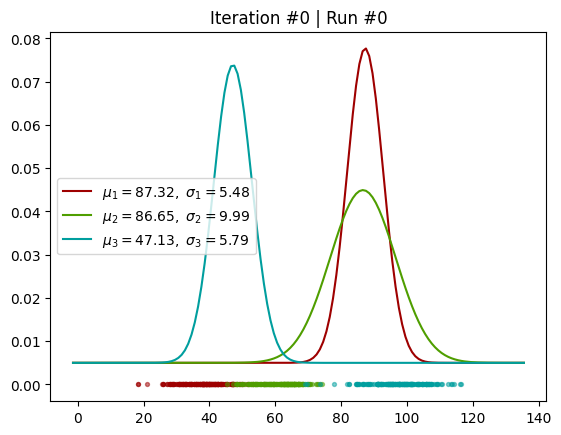

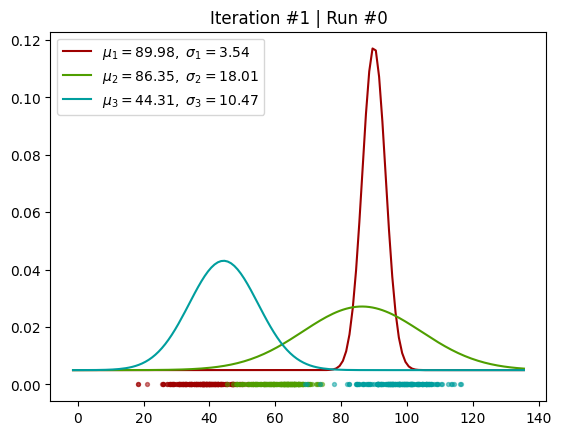

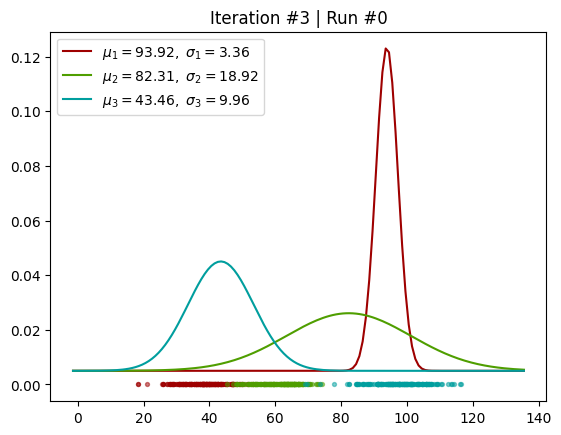

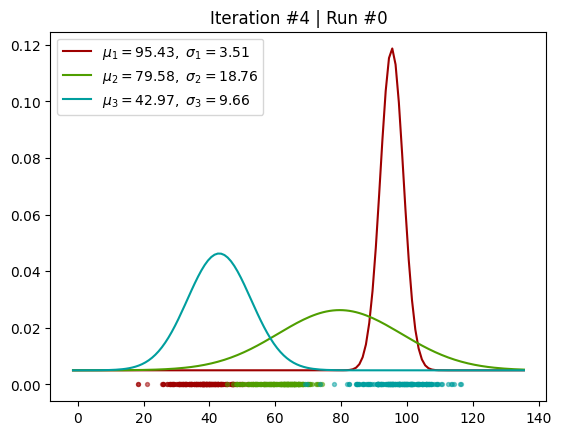

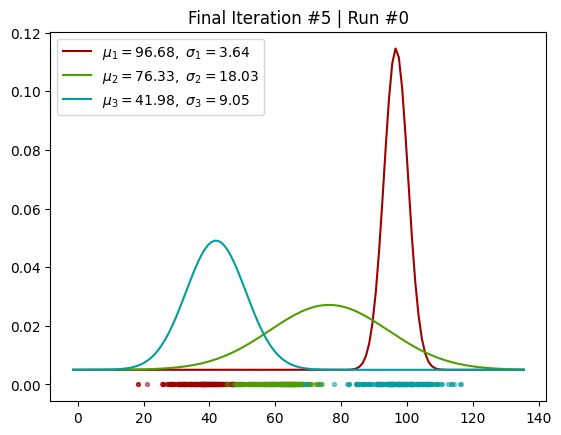

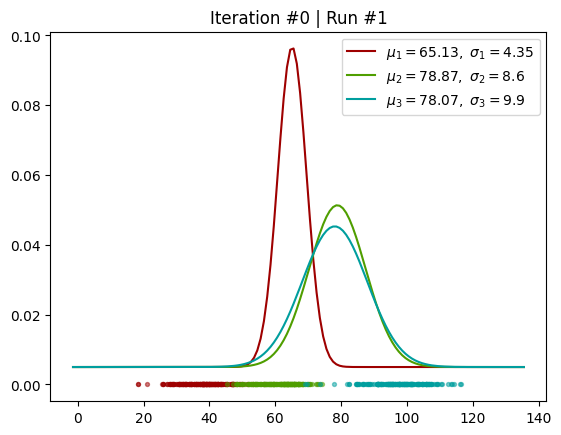

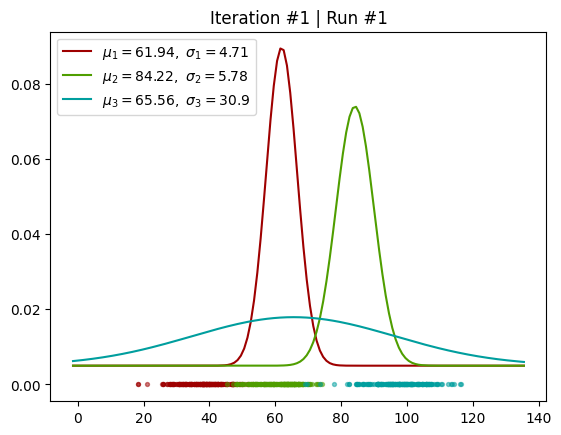

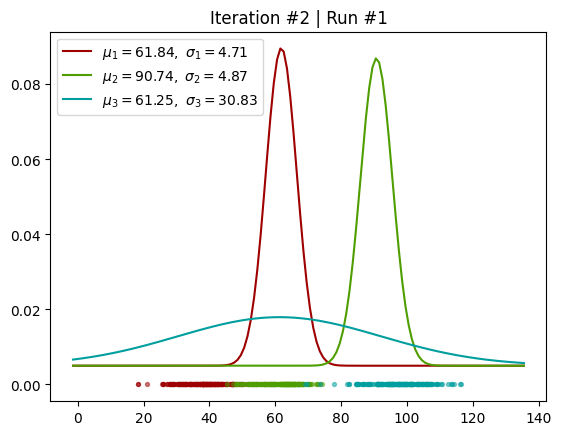

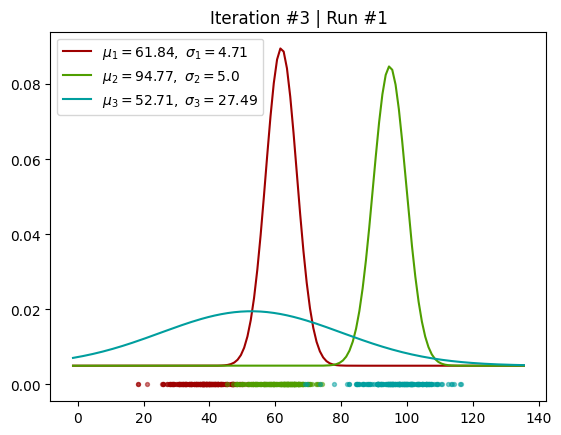

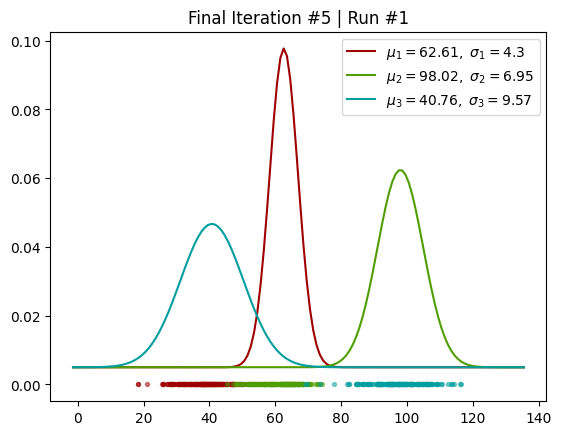

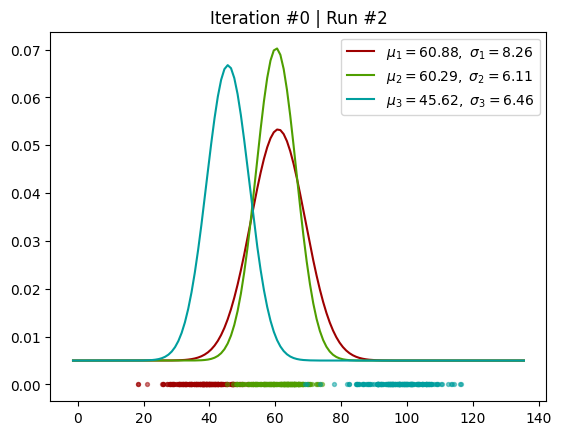

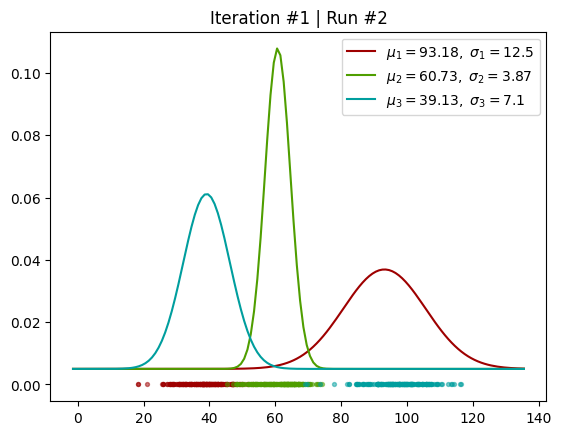

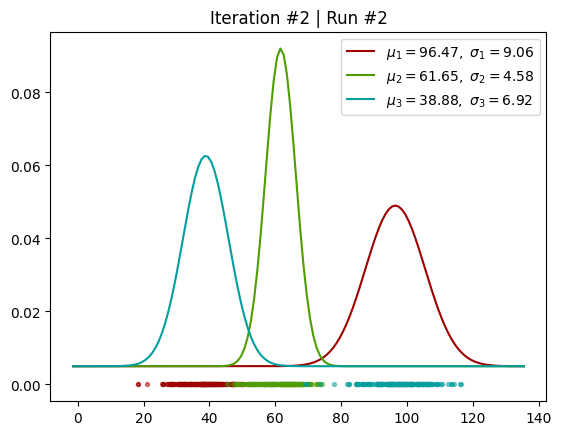

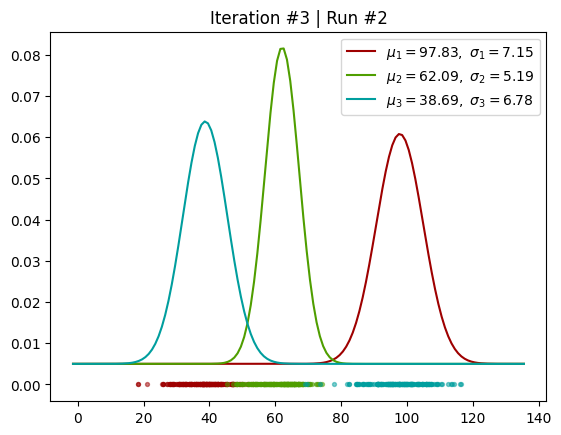

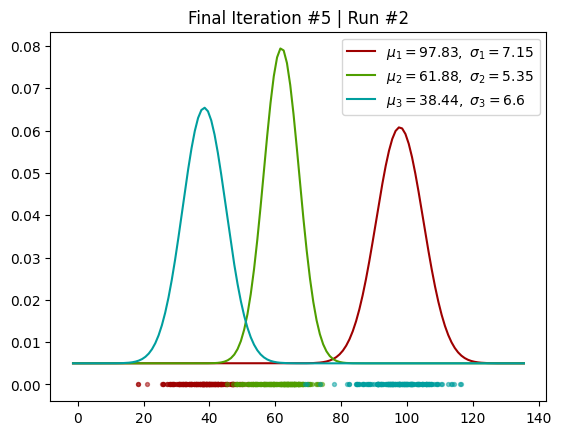

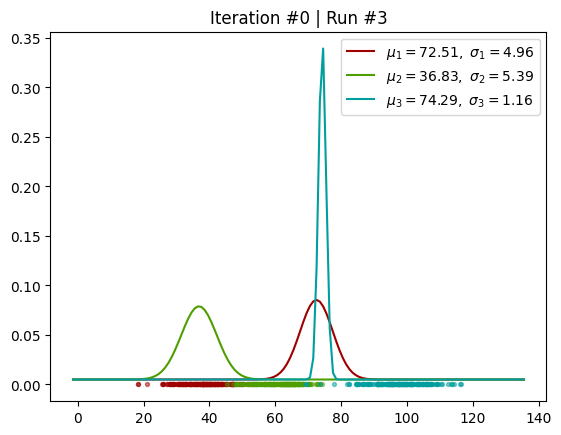

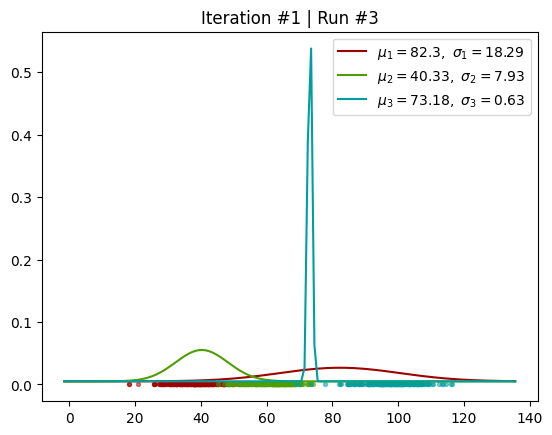

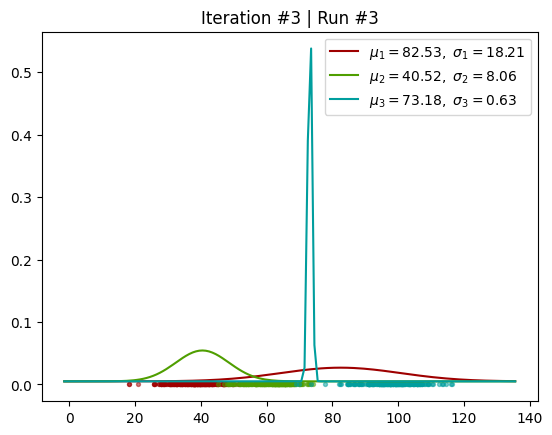

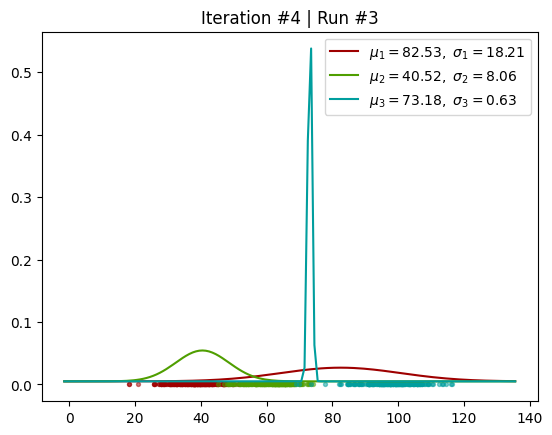

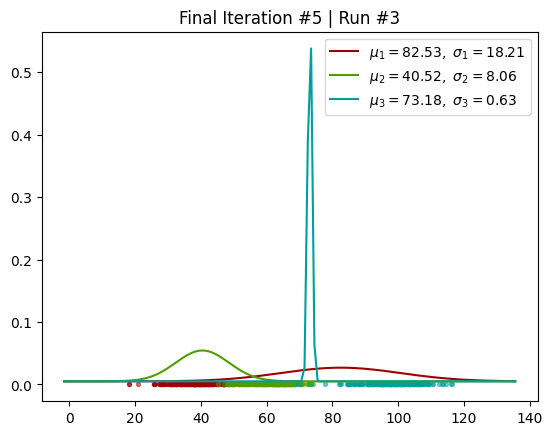

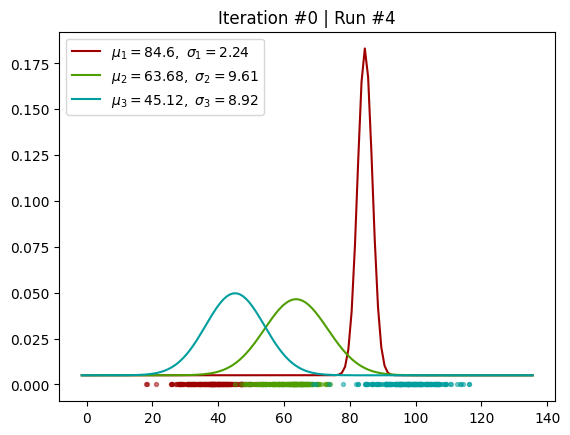

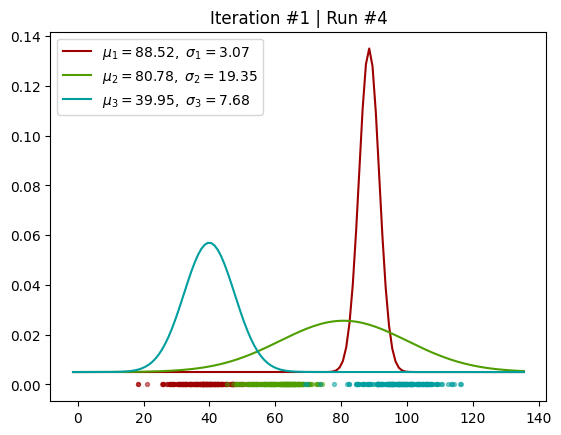

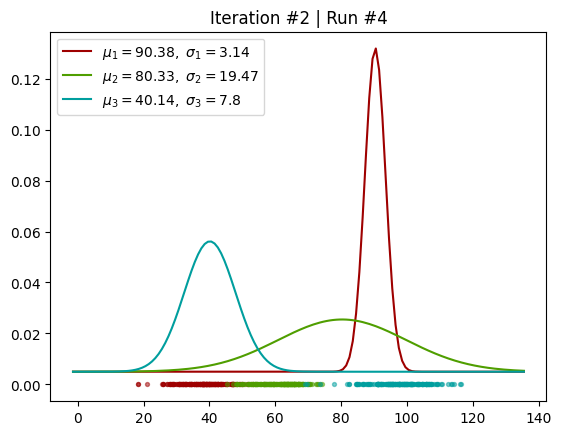

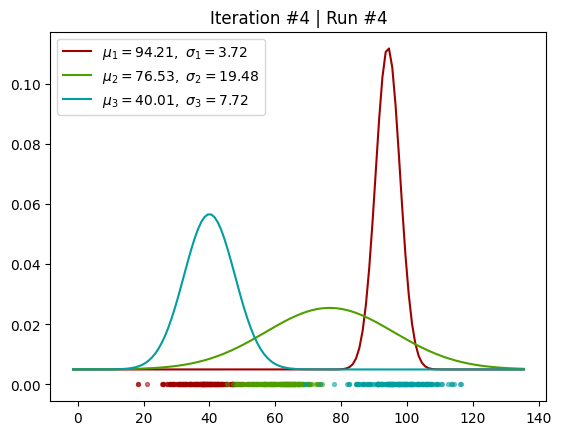

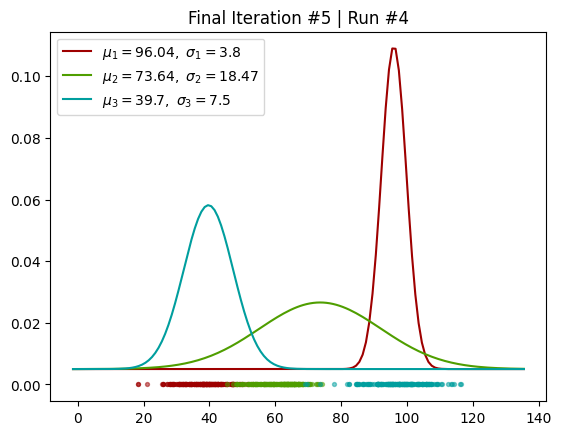

In [29]:
def run_algorithm(heuristic=False):
    initial_parameters = init_original_parameters(3)
    gaussian_samples = generate_data(200, initial_parameters)
    final_parameters = []
    for run in range(5):
        result_parameters = expectation_maximization(gaussian_samples, run_number=run, heuristic=heuristic)
        final_parameters.append(result_parameters)


run_algorithm()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


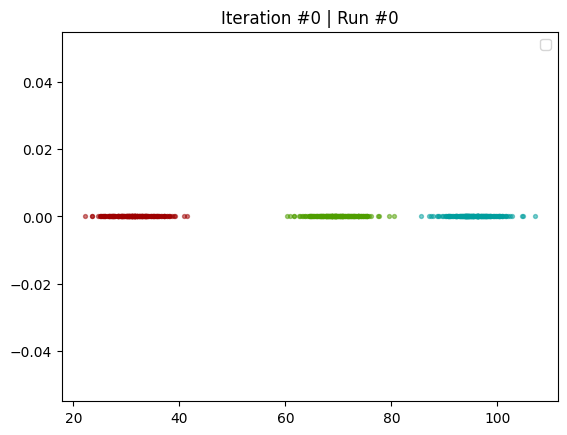

TypeError: string indices must be integers, not 'tuple'

In [32]:
run_algorithm(heuristic=True)

## **2. (40 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gamma)**

En esta sección, modificará el algoritmo de maximización de la esperanza anteriormente implementado para un modelo Gaussiano, para el modelo Gamma.

1. **(20 puntos)** Enliste e implemente todas las modificaciones necesarias tanto conceptualmente como en código para hacer que el algoritmo de maximización de la esperanza utilice un modelo Gamma

In [22]:
#Pending

2. **(5 puntos)** Implemente la función $\textit{generate\_data}$ la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K=2$ funciones de densidad Gamma. Genere los datos siguiendo tales distribuciones y retorne tal matriz de datos $N\in\mathbb{R}^{Nx1}$.

    a) Grafique los datos usando un $\textit{scatter plot}$ junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad **Gamma** usando los parámetros para inicializar los datos, en la misma figura (gráfico). Los parámetros serán escogidos por usted, muestre al menos 3 generaciones del dataset y comente el efecto de los parámetros.

In [23]:
SHAPE_MEAN = 2
SHAPE_STD = 2
SCALE_MEAN = 2
SCALE_STD = 1
LOC_STEP = 3
LOC_MAX_RANGE = 30


def generate_data_gamma(n_observations: int, k_parameters: int = 2):
    shapes = torch.abs(torch.randn(k_parameters)) * SHAPE_STD + SHAPE_MEAN
    scales = torch.abs(torch.randn(k_parameters)) * SCALE_STD + SCALE_MEAN
    distributions = torch.distributions.Gamma(shapes, scales)
    samples = distributions.sample(torch.Size([n_observations, ])).t()
    loc_range = torch.range(0, LOC_MAX_RANGE, LOC_STEP)[0:k_parameters].unsqueeze(-1)
    samples += loc_range
    return samples


def plot_observation_gamma(observation: torch.Tensor, show=True, color=None, title="", show_hist=True, show_curve=True,
                           fig=None, ax=None, y_adjustment=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    ax.scatter(observation, torch.zeros(observation.size()), s=6, alpha=0.5, color=color)
    if show_hist:
        ax.hist(observation, density=True, bins=20, alpha=0.5, color=color)
    if show_curve:
        # loc -> shift the distribution along the x-axis
        shape, loc, scale = gamma.fit(observation, floc=0)
        label = fr"$k={round(shape, 2)},\ \theta={round(scale, 2)}$"
        x_axis = torch.arange(observation.min().item(), observation.max().item(), 0.01)
        ax.plot(x_axis, gamma.pdf(x_axis, shape, loc, scale), color=color, label=label)
        ax.legend()
    if title != "":
        ax.set_title(title)
    if y_adjustment:
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min - 0.01, y_max)
    if show:
        plt.show()

def plot_gamma_distribution_and_observations(distribution_parameters, observations, title=""):
    """ What it does

    Summary

    Args:

    Returns:
    """
    fig, ax = plt.subplots()

    if observations.dim() > 1:
        for index, sample in enumerate(observations):
            plot_observation_gamma(sample, color=PALETTE[index % len(PALETTE)], show=False, show_hist=False, fig=fig,
                                   ax=ax, y_adjustment=False, show_curve=False)
    else:
        plot_observation_gamma(observations, show=False, show_hist=False, fig=fig, ax=ax, y_adjustment=False)

    for index, parameters in enumerate(distribution_parameters):
        shape = parameters[0]
        scale = parameters[1]
        min_value = torch.min(observations)
        max_value = torch.max(observations)
        dist = (max_value - min_value) * BELL_DISTANCE_FACTOR
        x_axis = torch.arange(min_value.item() - dist, max_value.item() + dist)
        ax.plot(x_axis, gamma.pdf(x_axis, shape, 0, scale) + BELL_Y_OFFSET,
                label=r'$k_' + str(index + 1) + r'=' + str(round(shape.item(), 2)) +
                      r',\ \theta_' + str(index + 1) + '=' + str(round(scale.item(), 2)) + r'$',
                color=PALETTE[index % len(PALETTE)])
    if title != "":
        ax.set_title(title)

    plt.legend()
    plt.show()

3.  **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (describalo en una tabla). Hagalo para los 3 conjuntos de datos generados anteriormente.

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteración y los parámetros iniciales.

    1) Comente los resultados.

In [24]:
def calculate_likelihood_gamma_observation(x_n, form_k, scale_th):
    def gamma_function(x, form, scale):
        factorial_part = torch.exp(torch.lgamma(form))
        return (x**(form - 1) * torch.exp(-x/scale)) / (factorial_part * scale**form)
    return gamma_function(x_n, form_k, scale_th)


K_START = 1
K_END = 10
SCALE_START = 1
SCALE_END = 5


def init_random_parameters_gamma(k_parameters=2, n_observations=200):
    shapes = (torch.rand(k_parameters) * (K_END - K_START) + K_START)
    scales = (torch.rand(k_parameters) * (SCALE_END - SCALE_START) + SCALE_START)
    distributions = torch.distributions.Gamma(shapes, scales)
    samples = distributions.sample(torch.Size([n_observations, ])).t()
    shapes = []
    scales = []
    for sample in samples:
        shape, loc, scale = gamma.fit(sample, floc=0)
        shapes.append(shape)
        scales.append(scale)
    return torch.stack((torch.tensor(shapes), torch.tensor(scales)), dim=1)


def recalculate_parameters_gamma(x_dataset, membership_data):
    values_per_membership = torch.transpose(membership_data, 0, 1) * x_dataset
    new_parameters = []
    for t_membership in values_per_membership:
        non_zero_mask = t_membership != 0
        t_membership = t_membership[non_zero_mask]
        if t_membership.sum() == 0 or t_membership.size()[0] == 1:
            params = init_random_parameters_gamma(1)
            new_shape = params[0][0]
            new_scale = params[0][1]
        else:
            new_shape, loc, new_scale = gamma.fit(t_membership, floc=0)
        new_parameters.append([new_shape, new_scale])
    return torch.Tensor(new_parameters)


def calculate_membership_dataset_gamma(observations, parameters):
    shape = parameters[:, 0].unsqueeze(0)
    scale = parameters[:, 1].unsqueeze(0)
    observations_expanded = observations.unsqueeze(-1)
    log_likelihoods = calculate_likelihood_gamma_observation(observations_expanded, shape, scale)
    max_values, _ = torch.max(log_likelihoods, dim=-1, keepdim=True)
    one_hot_membership_matrix = (log_likelihoods == max_values).to(torch.float)
    return one_hot_membership_matrix


def expectation_maximization_gamma(samples, iterations=5, distributions_to_plot=3, run_number=1):
    parameters = init_random_parameters_gamma(samples.size(0))
    plot_gamma_distribution_and_observations(parameters, samples, title=f"Iteration #0 | Run #{run_number}")
    plots_to_show = torch.randperm(iterations - 1)[:distributions_to_plot] + 1
    for iteration in range(1, iterations + 1):
        membership_data = calculate_membership_dataset_gamma(torch.flatten(samples), parameters)
        parameters = recalculate_parameters_gamma(torch.flatten(samples), membership_data)
        if iteration in plots_to_show:
            pass
            plot_gamma_distribution_and_observations(parameters, samples,
                                                        title=f'Iteration #{iteration} | Run #{run_number}')
    plot_gamma_distribution_and_observations(parameters, samples,
                                                title=f'Final Iteration #{iterations} | Run #{run_number}')
    return parameters

4. **(5 puntos)** Explique cual es el comportamiento esperado de utilizar la implementación del algoritmo de maximización de esperanza para una distribución Gamma, con un conjunto de datos que sigue una distribución Gaussiana y viceversa.

    a) **(10 puntos)** Realice un diseño experimental donde verifique lo anterior

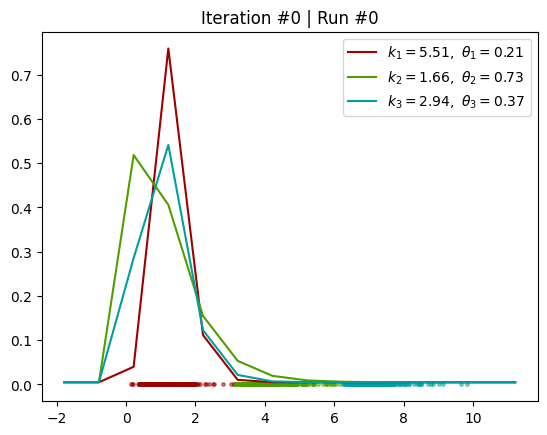

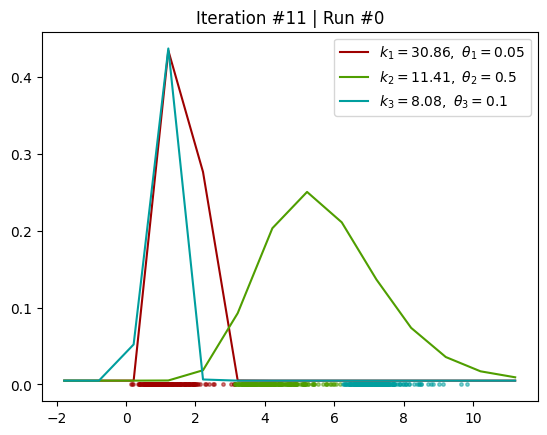

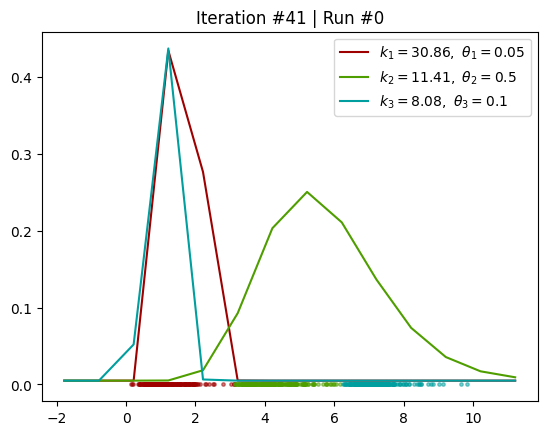

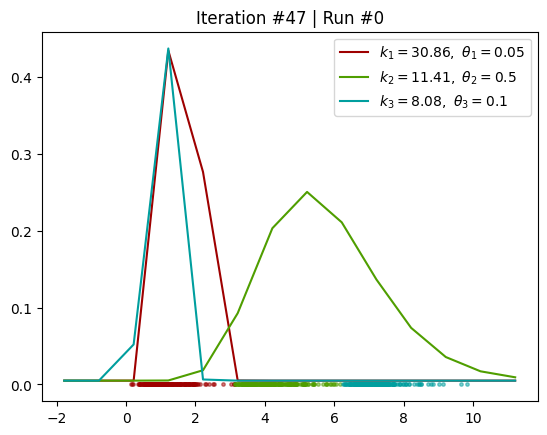

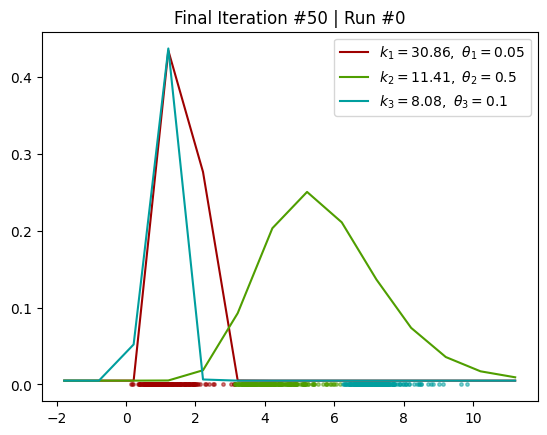

In [25]:
def run_algorithm_gamma():
    gamma_samples = generate_data_gamma(200, 3)
    # TODO Calculate original parameters from generated data
    final_parameters = []
    for run in range(1):
        result_parameters = expectation_maximization_gamma(gamma_samples, run_number=run, iterations=50)
        final_parameters.append(result_parameters)


run_algorithm_gamma()